First, we load our data.  This time, I'm adding a column of 1s directly to the dataframe, so that it's already there later on when we want to build new sets of training data.

 - note on binarize
 - matrix treatment

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')
data.insert(0, '1', 1)

X = data.as_matrix(columns=['1', 'alcohol', 'ash'])
y = np.matrix(label_binarize(data['class'], [1, 2, 3]))[:,0]

 - train / test sets

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

train: 142 test: 36


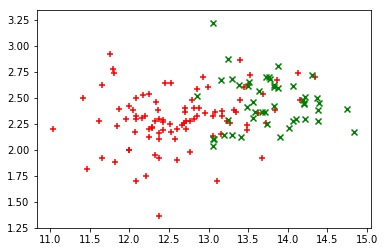

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def filter_by_label(X, y, value):
    return np.matrix([X[i,:] for i in range(len(X)) if y[i,0] == value])

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels.A.flatten())):
        points = np.matrix([xy[j,:] for j in range(len(xy)) if labels[j,0] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train[:,1:3], y_train)

In [4]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def predict(X, theta):
    return sigmoid(X * np.matrix(theta).T) >= 0.5

def cost(theta, X, y):
    theta = np.matrix(theta)
    
    h = sigmoid(np.matmul(X, theta.T))
    y1 = np.multiply(-y, np.log(h))
    y0 = np.multiply((1 - y), np.log(1 - h))
    j = np.sum(y1 - y0) / (len(X))
    return j

def gradient(theta, X, y):
    error = sigmoid(X * np.matrix(theta).T) - y
    grad = (1/len(X)) * np.matmul(X.T, error)
    
    return grad

In [5]:
import scipy.optimize as opt  

result = opt.fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X_train, y_train))
theta = result[0]

print('theta: ', theta)
print('cost:', cost(theta, X, y))

theta:  [-41.0785592    2.92096761   0.71740861]
cost: 0.36482918727


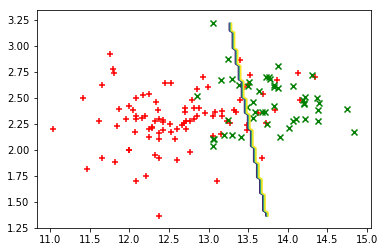

In [6]:
from matplotlib import cm

def plot_boundary(X, theta, pred):
    
    x_min, x_max = X[:,1].min(), X[:,1].max()
    y_min, y_max = X[:,2].min(), X[:,2].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    inputs = np.c_[np.ones(10000), xx.ravel(), yy.ravel()]
    predictions = pred(inputs, theta).reshape(xx.shape)

    plt.contour(xx, yy, predictions)
    
plot_points(X_train[:,1:3], y_train)
plot_boundary(X_train, theta, predict)

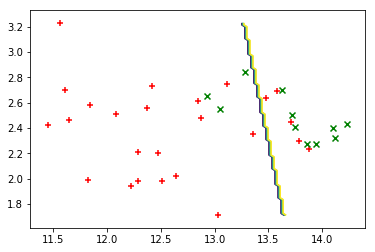

In [7]:
plot_boundary(X_test, theta, predict)
plot_points(X_test[:,1:3], y_test)

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('accuracy:', accuracy_score(y_test, predict(X_test, theta)))

accuracy: 0.777777777778


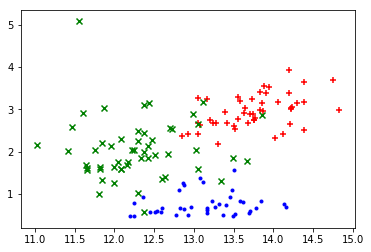

In [18]:
X = data.as_matrix(columns=['1', 'alcohol', 'flavanoids'])
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.matrix(label_binarize(y_train, [1, 2, 3]))

plot_points(X_train[:,1:3], y_train.argmax(axis=1))

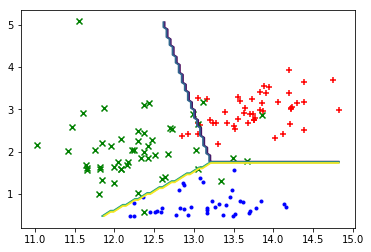

In [21]:
thetas = dict()
  
result = opt.fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X_train, y_train[:,0]))
theta1 = result[0]

result = opt.fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X_train, y_train[:,1]))
theta2 = result[0]

result = opt.fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X_train, y_train[:,2]))
theta3 = result[0]

thetas = [
    (1, theta1),
    (2, theta2),
    (3, theta3)
]

def predict2(X, thetas):

    labels = [t[0] for t in thetas]
    preds = [sigmoid(X * np.matrix(t[1]).T) for t in thetas]
    preds = np.column_stack(preds)

    argmax2 = preds.argmax(axis=1)
    argmax2 = np.vectorize(lambda v: labels[v])(preds.argmax(axis=1))


    return argmax2# + 1
    
  

plot_points(X_train[:,1:3], y_train.argmax(axis=1))
plot_boundary(X_train, thetas, predict2)


In [22]:

r = predict2(X_test, thetas)
#print(y_test)
#print(r)
print('accuracy:', accuracy_score(y_test, predict2(X_test, thetas).T))
print('precision:', precision_score(y_test, predict2(X_test, thetas).T, average='macro'))
print('recall:', recall_score(y_test, predict2(X_test, thetas).T, average='macro'))

ValueError: Found input variables with inconsistent numbers of samples: [36, 1]

In [ ]:
X = data.drop('class', 1).as_matrix()
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.matrix(label_binarize(y_train, [1, 2, 3]))

def cost2(theta, X, y, l):
    theta = np.matrix(theta)
    m = len(X)
    
    h = sigmoid(np.matmul(X, theta.T))
    y1 = np.multiply(-y, np.log(h))
    y0 = np.multiply((1 - y), np.log(1 - h))
    j = np.sum(y1 - y0) / m
    #z = j + (1 / (2 * m)) * np.square(theta).sum()
    #print(z)
    jreg = j + (1 / (2 * m)) * np.square(theta).sum()
    #print(jreg)
    return j

def gradient2(theta, X, y, l):
    error = sigmoid(X * np.matrix(theta).T) - y
    grad = (1/len(X)) * np.matmul(X.T, error)
    lm = (l / len(X)) * np.matrix(theta).T
    #print(grad)
    return grad + lm

result = opt.fmin_tnc(func=cost, x0=np.zeros(14), fprime=gradient, args=(X_train, y_train[:,0]))
theta1 = result[0]

result = opt.fmin_tnc(func=cost, x0=np.zeros(14), fprime=gradient, args=(X_train, y_train[:,1]))
theta2 = result[0]

result = opt.fmin_tnc(func=cost, x0=np.zeros(14), fprime=gradient, args=(X_train, y_train[:,2]))
theta3 = result[0]

print(theta1)
print(theta2)
print(theta3)
thetas = {
    1: theta1,
    2: theta2,
    3: theta3
}

print('accuracy:', accuracy_score(y_test, predict2(X_test, thetas).T))
print('precision:', precision_score(y_test, predict2(X_test, thetas).T, average='macro'))
print('recall:', recall_score(y_test, predict2(X_test, thetas).T, average='macro'))

result = opt.fmin_tnc(func=cost2, x0=np.zeros(14), fprime=gradient2, args=(X_train, y_train[:,0], 2))
theta1 = result[0]

result = opt.fmin_tnc(func=cost2, x0=np.zeros(14), fprime=gradient2, args=(X_train, y_train[:,1], 2))
theta2 = result[0]

result = opt.fmin_tnc(func=cost2, x0=np.zeros(14), fprime=gradient2, args=(X_train, y_train[:,2], 2))
theta3 = result[0]

#print(theta1)
#print(theta2)
thetas = {
    1: theta1,
    2: theta2,
    3: theta3
}

print('accuracy:', accuracy_score(y_test, predict2(X_test, thetas).T))
print('precision:', precision_score(y_test, predict2(X_test, thetas).T, average='macro'))
print('recall:', recall_score(y_test, predict2(X_test, thetas).T, average='macro'))

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

X = data.drop('class', 1).as_matrix()
y = data.as_matrix(columns=['class'])
y = np.matrix(label_binarize(y, [1, 2, 3]))[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

m = X_train.shape[0]
n = X_train.shape[1]
learning_rate = 0.001


W = tf.Variable(tf.zeros([n, 1]))
b = tf.Variable(tf.zeros([1]))

examples = tf.placeholder(tf.float32, [None, n]) # mnist data image of shape 28*28=784
labels = tf.placeholder(tf.float32, [None, 1]) # 0-9 digits recognition => 10 classes

#h = sigmoid(np.matmul(X, theta.T))
pred = tf.nn.sigmoid(tf.matmul(examples, W) + b)
y1 = tf.multiply(-labels, tf.log(pred))
y2 = tf.multiply(1-labels, tf.log(1 - pred))
#cost = tf.reduce_mean(-tf.reduce_sum(labels*tf.log(pred), reduction_indices=1))
cost = tf.reduce_mean(y1 - y2)
#cost = tf.nn.l2_loss(pred - labels)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)



    #y1 = np.multiply(-y, np.log(h))
    #y0 = np.multiply((1 - y), np.log(1 - h))
    #j = np.sum(y1 - y0) / (len(X))
    
# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
   
    
    for i in range(1, 1000):
        sess.run(optimizer, feed_dict={
            examples: X_train,
            labels: y_train
        }) 
        #print(cost)
        
    print('bias:', sess.run(b))
    print('weights:', sess.run(W))
    
    cls = sess.run(pred, feed_dict={
        examples: X_test
    })
    print(cls)
    
